__Library Installation(Optional)__

In [ ]:
pip install gym==0.22.0
pip install pygame
pip install pyglet
pip install torch
pip install matplotlib

__Library Import__

In [1]:
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [9]:
def rollout_frames(episode_length):
  test_env = gym.make('CartPole-v1', render_mode='rgb_array')
  frames = []
  state =  test_env.reset()
  for _ in range(episode_length):
    action = sac_trainer.policy_net.get_action(state, deterministic = DETERMINISTIC)
    state, reward, done, _ = test_env.step(action)
    img = np.asarray(test_env.render())
    img = img[0]
    frames.append(img)

  return frames

__ReplayBuffer__

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) # stack for each element
        '''
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        '''
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

__Critic Network/Q Network__

In [3]:
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, num_actions)

        self.linear4.weight.data.uniform_(-init_w, init_w)
        self.linear4.bias.data.uniform_(-init_w, init_w)

    def forward(self, state):
        x = F.tanh(self.linear1(state))
        x = F.tanh(self.linear2(x))
        # x = F.tanh(self.linear3(x))
        x = self.linear4(x)
        return x

__Actor Network__

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)


        self.output = nn.Linear(hidden_size, num_actions)

        self.num_actions = num_actions

    def forward(self, state, softmax_dim=-1):
        x = F.tanh(self.linear1(state))
        x = F.tanh(self.linear2(x))


        probs = F.softmax(self.output(x), dim=softmax_dim)

        return probs

    def evaluate(self, state, epsilon=1e-8):
        '''
        generate sampled action with state as input wrt the policy network;
        '''
        probs = self.forward(state, softmax_dim=-1)
        log_probs = torch.log(probs)
        z = (probs == 0.0).float() * epsilon
        log_probs = torch.log(probs + z)

        return log_probs

    def get_action(self, state, deterministic):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.forward(state)
        dist = Categorical(probs)

        if deterministic:
            action = np.argmax(probs.detach().cpu().numpy())
        else:
            action = dist.sample().squeeze().detach().cpu().numpy()
        return action

__SAC Trainer__

In [5]:
class SAC_Trainer():
    def __init__(self, replay_buffer, hidden_dim):
        self.replay_buffer = replay_buffer

        self.soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.log_alpha = torch.zeros(1, dtype=torch.float32, requires_grad=True, device=device)
        print('Soft Q Network (1,2): ', self.soft_q_net1)
        print('Policy Network: ', self.policy_net)

        for target_param, param in zip(self.target_soft_q_net1.parameters(), self.soft_q_net1.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_soft_q_net2.parameters(), self.soft_q_net2.parameters()):
            target_param.data.copy_(param.data)

        self.soft_q_criterion1 = nn.MSELoss()
        self.soft_q_criterion2 = nn.MSELoss()

        soft_q_lr = 3e-4
        policy_lr = 3e-4
        alpha_lr  = 3e-4

        self.soft_q_optimizer1 = optim.Adam(self.soft_q_net1.parameters(), lr=soft_q_lr)
        self.soft_q_optimizer2 = optim.Adam(self.soft_q_net2.parameters(), lr=soft_q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=alpha_lr)


    def update(self, batch_size, reward_scale=10., auto_entropy=True, target_entropy=-2, gamma=0.99, soft_tau=1e-2):
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        # print('sample:', state, action,  reward, done)

        state      = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action     = torch.Tensor(action).to(torch.int64).to(device)
        reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)  # reward is single value, unsqueeze() to add one dim to be [reward] at the sample dim;
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
        predicted_q_value1 = self.soft_q_net1(state)
        predicted_q_value1 = predicted_q_value1.gather(1, action.unsqueeze(-1))
        predicted_q_value2 = self.soft_q_net2(state)
        predicted_q_value2 = predicted_q_value2.gather(1, action.unsqueeze(-1))
        log_prob = self.policy_net.evaluate(state)
        with torch.no_grad():
            next_log_prob = self.policy_net.evaluate(next_state)
        # reward = reward_scale * (reward - reward.mean(dim=0)) / (reward.std(dim=0) + 1e-6) # normalize with batch mean and std; plus a small number to prevent numerical problem

    # Training Q Function
        self.alpha = self.log_alpha.exp()
        target_q_min = (next_log_prob.exp() * (torch.min(self.target_soft_q_net1(next_state),self.target_soft_q_net2(next_state)) - self.alpha * next_log_prob)).sum(dim=-1).unsqueeze(-1)
        target_q_value = reward + (1 - done) * gamma * target_q_min # if done==1, only reward
        q_value_loss1 = self.soft_q_criterion1(predicted_q_value1, target_q_value.detach())  # detach: no gradients for the variable
        q_value_loss2 = self.soft_q_criterion2(predicted_q_value2, target_q_value.detach())

        self.soft_q_optimizer1.zero_grad()
        q_value_loss1.backward()
        self.soft_q_optimizer1.step()
        self.soft_q_optimizer2.zero_grad()
        q_value_loss2.backward()
        self.soft_q_optimizer2.step()

    # Training Policy Function
        with torch.no_grad():
            predicted_new_q_value = torch.min(self.soft_q_net1(state),self.soft_q_net2(state))
        policy_loss = (log_prob.exp()*(self.alpha * log_prob - predicted_new_q_value)).sum(dim=-1).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # Updating alpha wrt entropy
        # alpha = 0.0  # trade-off between exploration (max entropy) and exploitation (max Q)
        if auto_entropy is True:
            alpha_loss = -(self.log_alpha * (log_prob + target_entropy).detach()).mean()
            # print('alpha loss: ',alpha_loss)
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
        else:
            self.alpha = 1.
            alpha_loss = 0

        # print('q loss: ', q_value_loss1.item(), q_value_loss2.item())
        # print('policy loss: ', policy_loss.item() )

    # Soft update the target value net
        for target_param, param in zip(self.target_soft_q_net1.parameters(), self.soft_q_net1.parameters()):
            target_param.data.copy_(  # copy data value into target parameters
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
        for target_param, param in zip(self.target_soft_q_net2.parameters(), self.soft_q_net2.parameters()):
            target_param.data.copy_(  # copy data value into target parameters
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

        return predicted_new_q_value.mean()


    def save_model(self, path):
        torch.save(self.soft_q_net1.state_dict(), path+'_q1')
        torch.save(self.soft_q_net2.state_dict(), path+'_q2')
        torch.save(self.policy_net.state_dict(), path+'_policy')

    def load_model(self, path):
        self.soft_q_net1.load_state_dict(torch.load(path+'_q1'))
        self.soft_q_net2.load_state_dict(torch.load(path+'_q2'))
        self.policy_net.load_state_dict(torch.load(path+'_policy'))

        self.soft_q_net1.eval()
        self.soft_q_net2.eval()
        self.policy_net.eval()

__PARAMS__

In [6]:
device = torch.device("cpu")
replay_buffer_size = 1e6
replay_buffer = ReplayBuffer(replay_buffer_size)

# choose env
env = gym.make('CartPole-v1')

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.n  # discrete

# hyper-parameters for RL training
max_episodes  = 10000
max_steps = 200
frame_idx   = 0
batch_size  = 256
update_itr = 1
AUTO_ENTROPY=True
DETERMINISTIC=False
hidden_dim = 64
rewards     = []
!mkdir checkpoints
model_path = 'checkpoints'
target_entropy = -1.*action_dim
sac_trainer=SAC_Trainer(replay_buffer, hidden_dim=hidden_dim)

mkdir: cannot create directory ‘checkpoints’: File exists


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Soft Q Network (1,2):  SoftQNetwork(
  (linear1): Linear(in_features=4, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=2, bias=True)
)
Policy Network:  PolicyNetwork(
  (linear1): Linear(in_features=4, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)


__Main Training Loop__

In [12]:
max_episodes = 30
for eps in range(max_episodes):
        state =  env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action = sac_trainer.policy_net.get_action(state, deterministic = DETERMINISTIC)
            next_state, reward, done, _ = env.step(action)
            #env.render()
            # env.render()

            replay_buffer.push(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward
            frame_idx += 1


            if len(replay_buffer) > batch_size:
                for i in range(update_itr):
                    _=sac_trainer.update(batch_size, reward_scale=1., auto_entropy=AUTO_ENTROPY, target_entropy=target_entropy)

            if done:
                break

        if eps % 20 == 0 and eps>0: # plot and model saving interval
            #plt.plot(rewards)
            #np.save('rewards', rewards)
            sac_trainer.save_model(model_path + f'_{eps}')
        print('Episode: ', eps, '| Episode Reward: ', episode_reward, '| Episode Length: ', step)
        rewards.append(episode_reward)

Episode:  0 | Episode Reward:  17.0 | Episode Length:  16
Episode:  1 | Episode Reward:  30.0 | Episode Length:  29
Episode:  2 | Episode Reward:  27.0 | Episode Length:  26
Episode:  3 | Episode Reward:  10.0 | Episode Length:  9
Episode:  4 | Episode Reward:  13.0 | Episode Length:  12
Episode:  5 | Episode Reward:  13.0 | Episode Length:  12
Episode:  6 | Episode Reward:  10.0 | Episode Length:  9
Episode:  7 | Episode Reward:  27.0 | Episode Length:  26
Episode:  8 | Episode Reward:  23.0 | Episode Length:  22
Episode:  9 | Episode Reward:  14.0 | Episode Length:  13
Episode:  10 | Episode Reward:  42.0 | Episode Length:  41
Episode:  11 | Episode Reward:  40.0 | Episode Length:  39
Episode:  12 | Episode Reward:  33.0 | Episode Length:  32
Episode:  13 | Episode Reward:  19.0 | Episode Length:  18
Episode:  14 | Episode Reward:  49.0 | Episode Length:  48
Episode:  15 | Episode Reward:  35.0 | Episode Length:  34
Episode:  16 | Episode Reward:  17.0 | Episode Length:  16
Episode: 

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


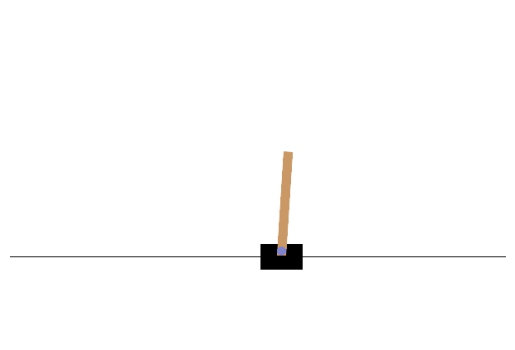

In [13]:
frames = rollout_frames(100)

# Function to update the plot for each frame
def update_plot(frame_number, frames, img_plot):
    img_plot.set_data(frames[frame_number])
    return [img_plot]

# Set up the figure
fig, ax = plt.subplots()
ax.axis('off')  # Hide axes
img_plot = ax.imshow(frames[0], animated=True)

# Create the animation
ani = FuncAnimation(fig, update_plot, frames=len(frames), fargs=(frames, img_plot), interval=50, blit=True)

# Display the animation
HTML(ani.to_jshtml())